<a href="https://colab.research.google.com/github/HrithikBT/Emotion_Analysis/blob/master/savee_cnn1d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
pip install -q pysoundfile

In [0]:
pip install -q noisereduce

In [0]:
pip install -q librosa

In [0]:
pip install -q h5py

In [0]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2019-12-15 21:16:45--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.86.66.223, 52.4.202.19, 52.86.175.38, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.86.66.223|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.1’

ngrok-stable-linux- 100%[===================>]  13.13M  19.4MB/s    in 0.7s    

2019-12-15 21:16:46 (19.4 MB/s) - ‘ngrok-stable-linux-amd64.zip.1’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:
LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

In [0]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

http://57306fba.ngrok.io


In [0]:
from tensorboardcolab import *

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:

#Model Implementation On SAVEE
import soundfile # to read audio file
import numpy as np
import librosa # to extract speech features
import glob
import os
import pickle # to save model after training
from sklearn.model_selection import train_test_split # for splitting training and testing
from sklearn.neural_network import MLPClassifier # multi-layer perceptron model
from sklearn.metrics import accuracy_score # to measure how good we are
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Activation, Dense,Conv1D,Dropout,MaxPooling1D,Flatten
from tensorflow import keras
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report,accuracy_score
from tensorflow.keras.models import model_from_json,load_model
from tensorflow.keras.callbacks import TensorBoard

Using TensorFlow backend.


In [0]:
def extract_feature(file_name, **kwargs):
    """
    Extract feature from audio file `file_name`
        Features supported:
            - MFCC (mfcc)
            - Chroma (chroma)
            - MEL Spectrogram Frequency (mel)
            - Contrast (contrast)
            - Tonnetz (tonnetz)
        e.g:
        `features = extract_feature(path, mel=True, mfcc=True)`
    """
    mfcc = kwargs.get("mfcc")
    chroma = kwargs.get("chroma")
    mel = kwargs.get("mel")
    contrast = kwargs.get("contrast")
    tonnetz = kwargs.get("tonnetz")
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate = sound_file.samplerate
        if chroma or contrast:
            stft = np.abs(librosa.stft(X))
        result = np.array([])
        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result = np.hstack((result, mfccs))
        if chroma:
            chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result = np.hstack((result, chroma))
        if mel:
            mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            result = np.hstack((result, mel))
        if contrast:
            contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
            result = np.hstack((result, contrast))
        if tonnetz:
            tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
            result = np.hstack((result, tonnetz))
    return result

In [0]:
 # all emotions on TESS dataset

int2emotion = {
    "n": "neutral",
    "h": "happy",
    "sa": "sad",
    "a": "angry",
    "f": "fearful",
    "d": "disgust",
    "su": "surprised"
}

AVAILABLE_EMOTIONS = {
    "angry",
    "sad",
    "neutral",
    "happy",
    "fearful",
    "surprised",
    "disgust"
}

In [0]:
def load_data(test_size=0.2):
    X, y = [], []
    for file in glob.glob("/content/drive/My Drive/Colab Notebooks/savee/AudioData/*/*.wav"):
        # get the base name of the audio file
        basename = os.path.basename(file)
        # get the emotion label
        emo = basename.split(".")[0]
        #print(emo)
        if emo[1].isdigit():
            emotion = int2emotion[emo[:1]]
           # print(emotion)
        else :
            emotion = int2emotion[emo[:2]]
           # print(emotion)

        # we allow only AVAILABLE_EMOTIONS we set
        if emotion not in AVAILABLE_EMOTIONS:
            continue
        # extract speech features
        features = extract_feature(file, mfcc=True, chroma=True, mel=True,contrast=True,tonnetz=True)
        # add to data
       # print(emotion)
        X.append(features)
        y.append(emotion)
    # split the data to training and testing and return it
    return train_test_split(np.array(X), y, test_size=test_size, random_state=7)

In [0]:
X_train, X_test, y_train, y_test = load_data(test_size=0.10)
X_train, X_predict, y_train, y_predict = train_test_split(np.array(X_train), y_train, test_size=.12, random_state=7)
#'''
y_train = np.array(y_train)
#print(np.unique(y_train))
y_test = np.array(y_test)
y_predict = np.array(y_predict)
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))
y_predict = np_utils.to_categorical(lb.fit_transform(y_predict))

In [0]:
# print some details
# number of samples in training data
print("[+] Number of training samples:", X_train.shape[0])
# number of samples in testing data
print("[+] Number of testing samples:", X_test.shape[0])
# number of features used
# this is a vector of features extracted 
# using extract_features() function
print("[+] Number of features:", X_train.shape[1])

[+] Number of training samples: 386
[+] Number of testing samples: 49
[+] Number of features: 193


In [0]:
x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)
X_predict = np.expand_dims(X_predict,axis=2)

In [0]:
model = models.Sequential()
model.add(Conv1D(256, 5,padding='same', input_shape=(193,1))) #1
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same')) #
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same')) #3
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same')) #4
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same')) #5
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Conv1D(128, 5,padding='same')) #6
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(7)) #7
model.add(Activation('softmax'))

In [0]:
opt = keras.optimizers.Adam(lr=0.00001, decay=1e-6)

In [0]:
tbCallBack = TensorBoard(log_dir='./log', histogram_freq=1,
                         write_graph=True,
                         write_grads=True,
                         write_images=True)

In [0]:
# Compile Model
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

In [0]:
# Fit Model
import matplotlib.pyplot as plt
history = model.fit(np.array(x_traincnn), y_train, batch_size=12, epochs=700, validation_data=(np.array(x_testcnn), y_test))

Train on 386 samples, validate on 49 samples
Epoch 1/700
386/386 [==============================] - 2s 6ms/sample - loss: 0.2536 - accuracy: 0.9197 - val_loss: 1.1408 - val_accuracy: 0.6327
Epoch 2/700
386/386 [==============================] - 2s 6ms/sample - loss: 0.2609 - accuracy: 0.9067 - val_loss: 1.2865 - val_accuracy: 0.6122
Epoch 3/700
386/386 [==============================] - 2s 6ms/sample - loss: 0.2672 - accuracy: 0.9016 - val_loss: 1.0574 - val_accuracy: 0.6939
Epoch 4/700
386/386 [==============================] - 2s 6ms/sample - loss: 0.2558 - accuracy: 0.9145 - val_loss: 1.1251 - val_accuracy: 0.6327
Epoch 5/700
386/386 [==============================] - 2s 6ms/sample - loss: 0.2686 - accuracy: 0.9067 - val_loss: 1.3351 - val_accuracy: 0.6327
Epoch 6/700
386/386 [==============================] - 2s 6ms/sample - loss: 0.2519 - accuracy: 0.9067 - val_loss: 1.0921 - val_accuracy: 0.6735
Epoch 7/700
386/386 [==============================] - 2s 6ms/sample - loss: 0.2539 -

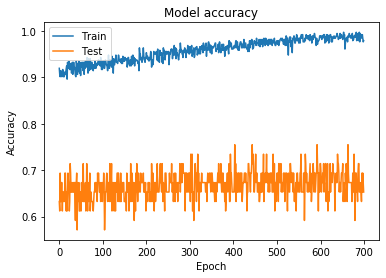

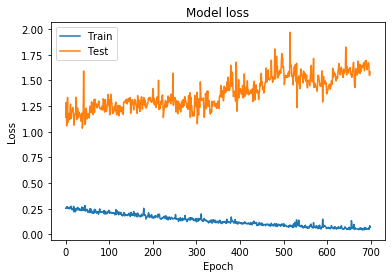

In [0]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

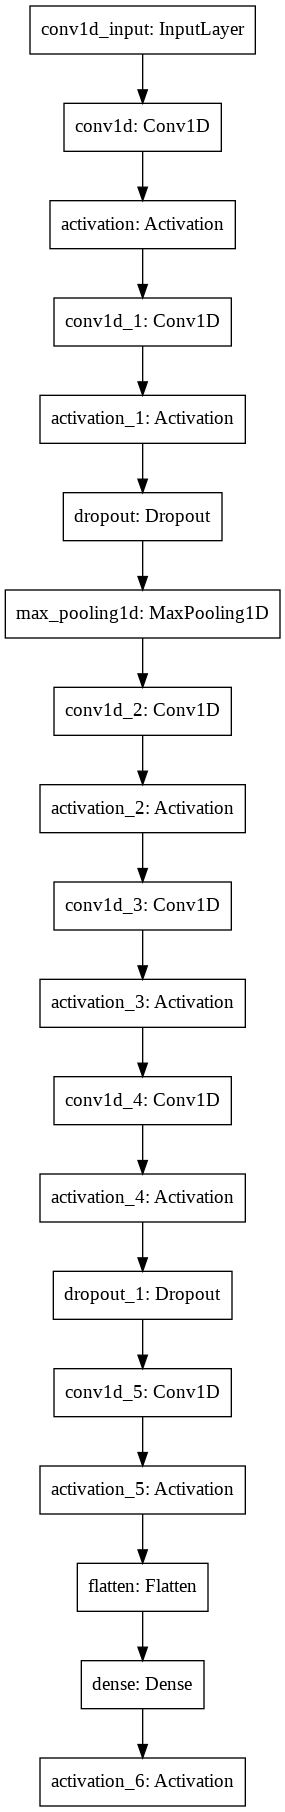

In [0]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

In [0]:
preds = model.predict(X_predict)

In [0]:
print(classification_report(np.argmax(y_predict,axis=1), np.argmax(preds,axis=1)))
# calculate the accuracy
accuracy = accuracy_score(y_true=np.argmax(y_predict,axis=1), y_pred=np.argmax(preds,axis=1))

print("Accuracy: {:.2f}%".format(accuracy*100))
# now we save the model
# make result directory if doesn't exist yet

#
#'''

              precision    recall  f1-score   support

           0       0.17      0.33      0.22         6
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         5
           4       0.51      1.00      0.68        19
           5       0.00      0.00      0.00         8
           6       0.00      0.00      0.00         4

    accuracy                           0.40        53
   macro avg       0.10      0.19      0.13        53
weighted avg       0.20      0.40      0.27        53

Accuracy: 39.62%


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [0]:
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

In [0]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

In [0]:
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

In [0]:
# save model and architecture to single file
model.save("/content/drive/My Drive/Saved_models/model_savee.h5")
print("Saved model to disk")

Saved model to disk


In [0]:
# load model
model = load_model("/content/drive/My Drive/Saved_models/model_savee.h5")
# summarize model.
model.summary()
# load dataset

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 193, 256)          1536      
_________________________________________________________________
activation_49 (Activation)   (None, 193, 256)          0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 193, 128)          163968    
_________________________________________________________________
activation_50 (Activation)   (None, 193, 128)          0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 193, 128)          0         
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 24, 128)           0         
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 24, 128)          